# HPPC Temperature Sensitivity

Study the influence of temperature on HPPC pulses.

Parse HPPC data written on the Biologic.

Cells used in this study are from GM2022JULY.

10/27/2022

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml
import glob
import re 
from pathlib import Path
from scipy.signal import savgol_filter
from scipy import fftpack

from matplotlib import pyplot as plt
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [2]:
plotter.initialize(plt)
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

# Define helper functions

In [3]:
def file_list_to_df_list(file_list):

    df_list = []

    for file in file_list:
        
        # First read in the file to get the number of header lines
        df = pd.read_table(file, encoding='iso8859', on_bad_lines='skip')
        num_header_lines = int("".join(re.findall(r'\d', df.iloc[0][0]))) - 1
        
        # Read in the same file again, this time excluding the headers
        df = pd.read_table(file, encoding='iso8859', skiprows=num_header_lines)

        df_list.append(df)
        
        print(f'The file "{file.name}" contains {len(df.columns)} columns.')
        
        if 'Analog IN 1/V' in df.columns:
            print('Analog IN 1 is present in this file.')

    return df_list

In [4]:
def make_plot(file : Path, df: pd.DataFrame):

    plt.figure(figsize=(10, 5))
    plt.title(file.name)
    ax1 = plt.gca()
    ax1.plot(df['time/s']/3600, df['Ecell/V'], label='Main')
    if 'Analog IN 1/V' in df.columns:
        ax1.plot(df['time/s']/3600, df['Analog IN 1/V'], label='Analog IN 1')
    if 'Temperature/°C' in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(df['time/s']/3600, df['Temperature/°C'], color='r')
    ax1.legend()
    ax1.set_xlabel('Time (hrs)')
    ax1.set_ylabel('Voltage (V)')
    ax2.set_ylabel('Temperature (C)')

# File inspection

Inspect all of the files to identify the relevant ones. Flag the relevant ones manually.

The file "GMJuly2022_CELL001_BOL_Characterization_01_MB_CA8.mpt" contains 41 columns.
The file "GMJuly2022_CELL001_BOL_1_P45C_02_BCD_CA8.mpt" contains 29 columns.
The file "GMJuly2022_CELL001_BOL_1_P45C_01_MB_CA8.mpt" contains 46 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_0C_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_0C_02_BCD_CA8.mpt" contains 21 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_0C_R2_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_0C_R2_02_BCD_CA8.mpt" contains 29 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_m10C_R2_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_m10C_R2_02_BCD_CA8.mpt" contains 29 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_p25C_R3_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_p25C_R3_02_BCD_CA8.mpt" contains 29 columns.
The file "GMJuly202

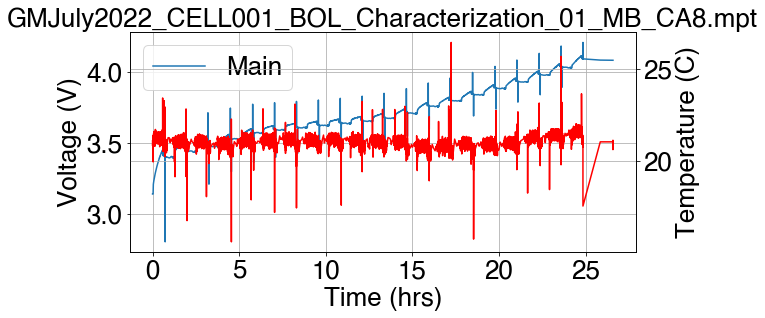

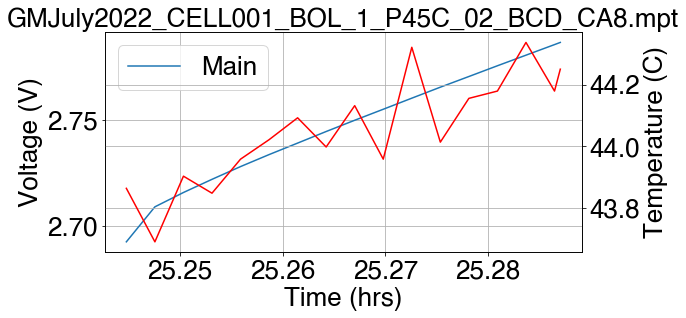

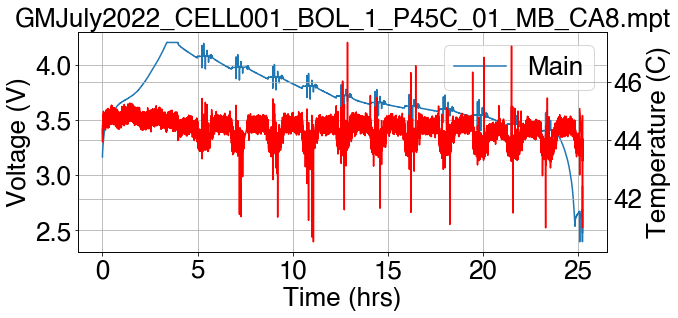

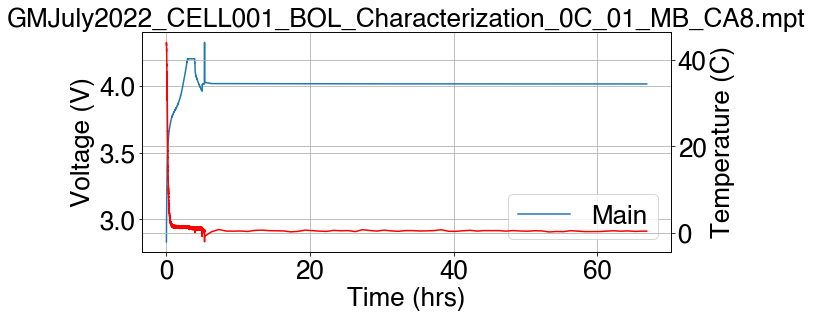

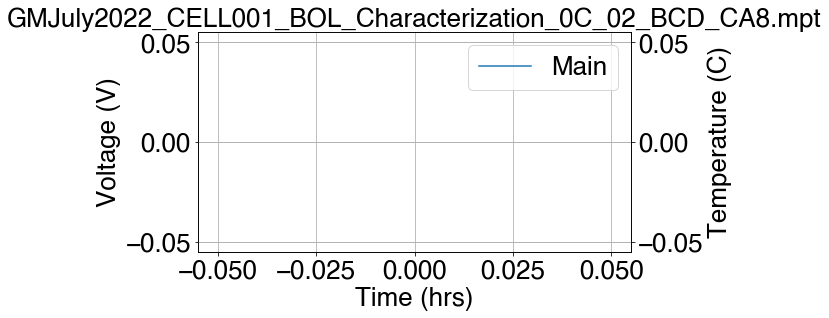

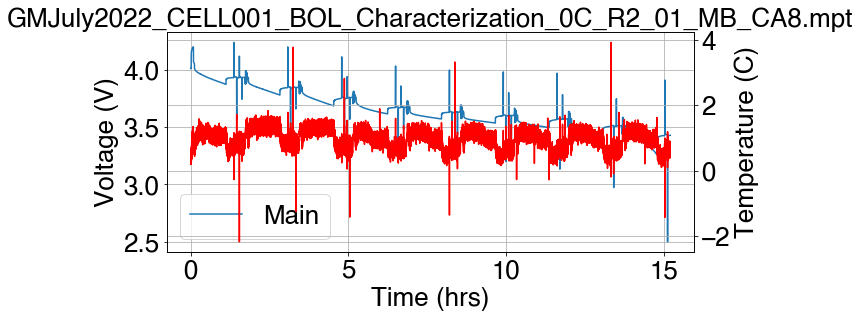

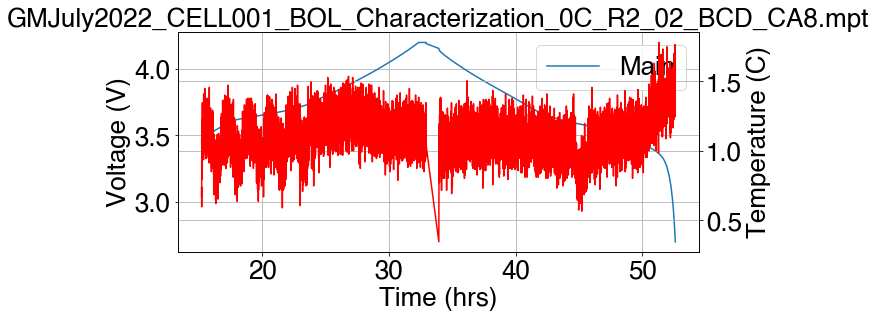

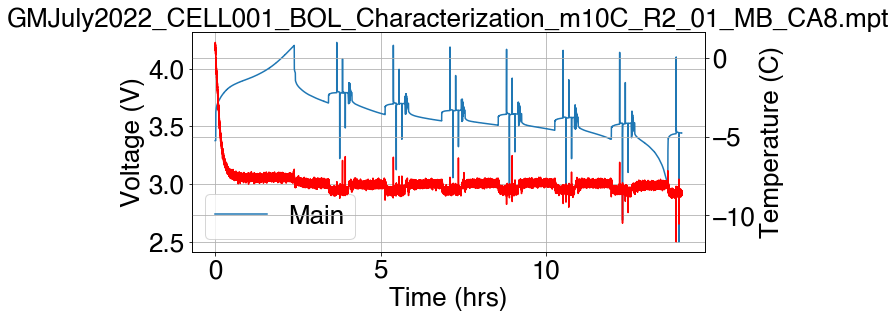

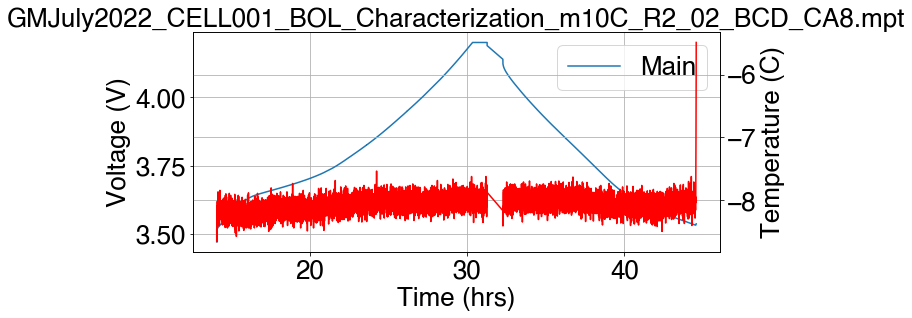

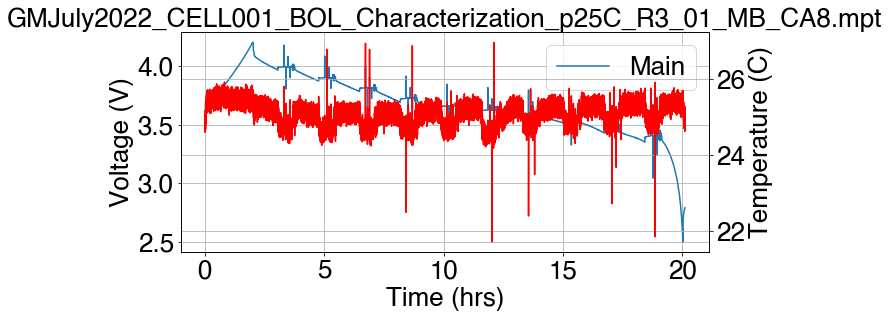

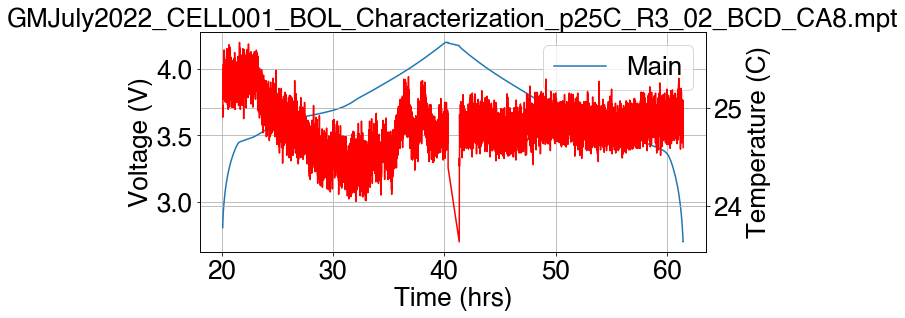

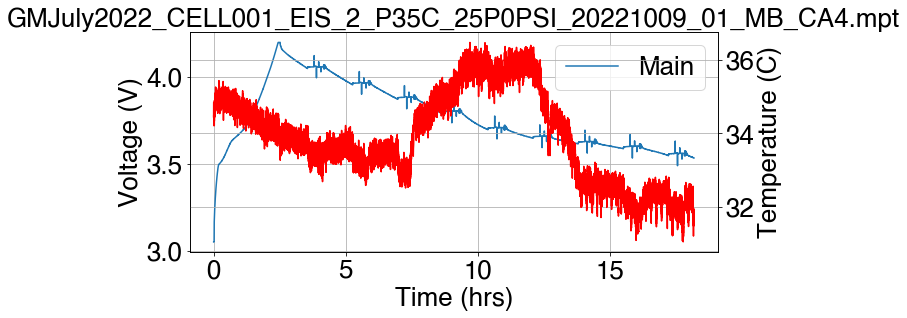

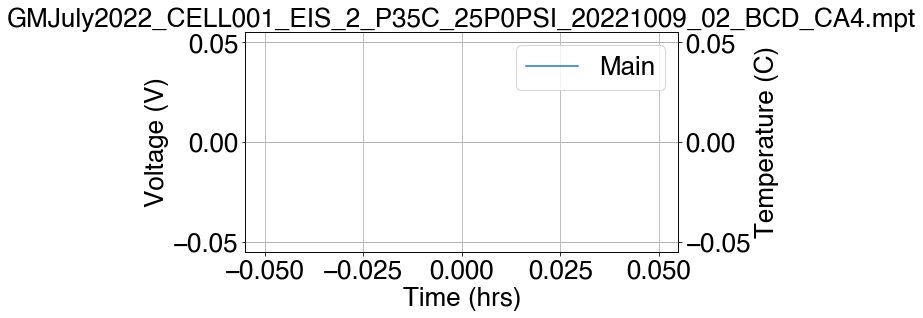

In [5]:
folder_list = ['GM2022JULY']

for folder in folder_list:

    data_path = f'{paths["data"]}/2022-10-09-biologic-pc/{folder}'
    file_list = sorted(Path(data_path).glob("*.mpt"), key=os.path.getmtime)

    df_list = file_list_to_df_list(file_list)

    for file, df in zip(file_list, df_list):
        make_plot(file, df)

# Process the relevant HPPC files

In [6]:
NOMINAL_CAPACITY_AH = 3.329
# Highest measured capacity (45C test) which will stand in as the nominal 
# Capacity for this set of cells. Note that we measure as high as 3.74 Ah on 
# slow-rate discharges during RPTs. We will use the capacity measured directly
# during the HPPC test to normalize SOC, just for this comparison.

files_list = [
              'GM2022JULY/GMJuly2022_CELL001_BOL_1_P45C_01_MB_CA8.mpt',
              'GM2022JULY/GMJuly2022_CELL001_BOL_Characterization_0C_R2_01_MB_CA8.mpt',
              'GM2022JULY/GMJuly2022_CELL001_BOL_Characterization_m10C_R2_01_MB_CA8.mpt',
              'GM2022JULY/GMJuly2022_CELL001_BOL_Characterization_p25C_R3_01_MB_CA8.mpt',
              ]

temperature_targets = [45, 0, -10, 25]

file_paths = []

for file_name in files_list:
    file_paths.append(Path(f'{paths["data"]}/2022-10-09-biologic-pc/{file_name}'))  

df_list = file_list_to_df_list(file_paths)

The file "GMJuly2022_CELL001_BOL_1_P45C_01_MB_CA8.mpt" contains 46 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_0C_R2_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_m10C_R2_01_MB_CA8.mpt" contains 44 columns.
The file "GMJuly2022_CELL001_BOL_Characterization_p25C_R3_01_MB_CA8.mpt" contains 44 columns.


In [7]:
df.columns

Index(['mode', 'ox/red', 'error', 'control changes', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', 'I Range',
       'Q charge/discharge/mA.h', 'Temperature/°C', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'control/V', 'control/mA', 'P/W',
       'Unnamed: 20'],
      dtype='object')

# Come up with a data parsing strategy

Inspect the raw data columns to see what we can do here.



Text(0.5, 0, 'Time (hours)')

<Figure size 1008x864 with 0 Axes>

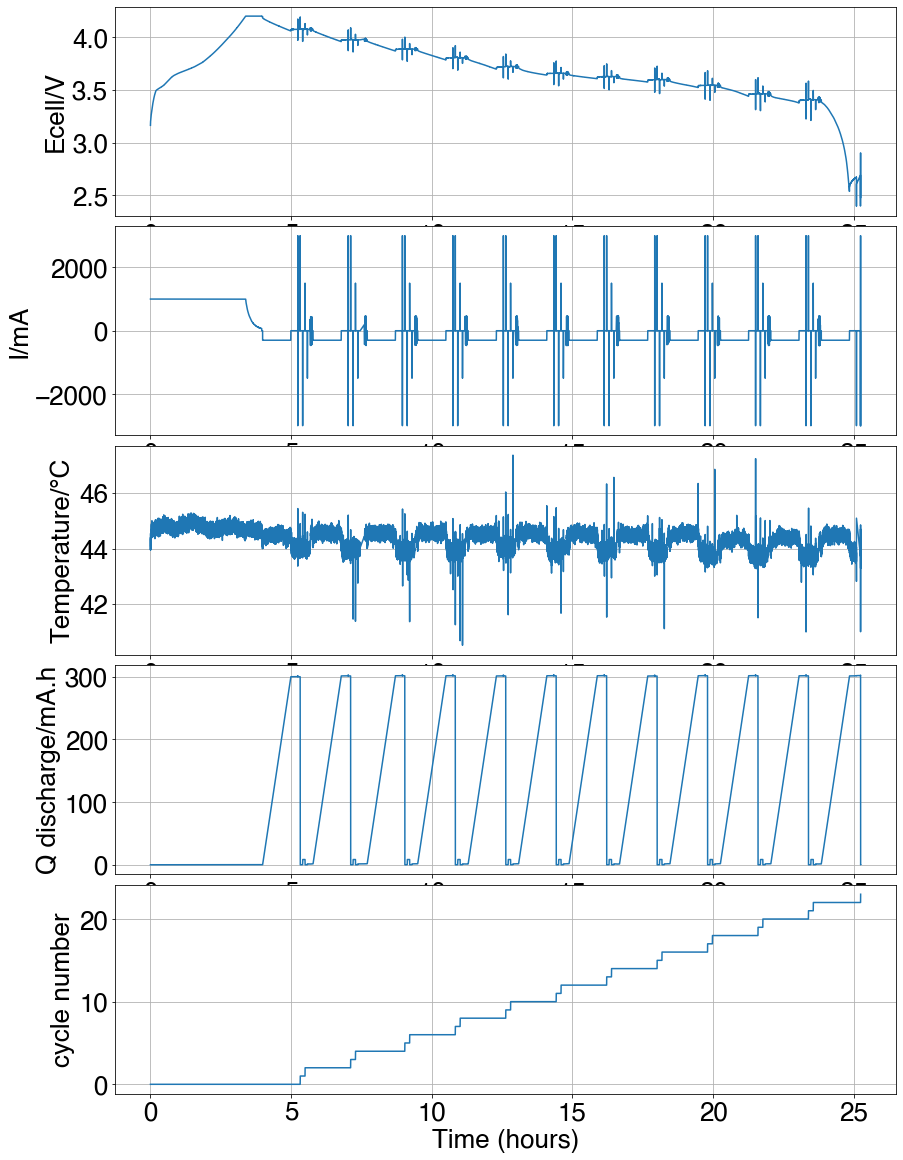

In [8]:
fh = plt.figure()

curr_df = df_list[0]

vars = ['Ecell/V',
        'I/mA',
        'Temperature/°C',
        'Q discharge/mA.h',
        'cycle number'
        ]

gridspec = dict(hspace=0.05, height_ratios=np.ones(len(vars)))

fig, axs = plt.subplots(nrows=len(vars), ncols=1, 
                                gridspec_kw=gridspec, 
                                figsize=(14, 4*len(vars)))

for var, ax in zip(vars, axs):

    ax.plot(curr_df['time/s']/3600, curr_df[var])
    ax.set_ylabel(var)

axs[-1].set_xlabel('Time (hours)')

# Trial and error optimization of pulse identification method

Return the processed output as a Pandas DataFrame.

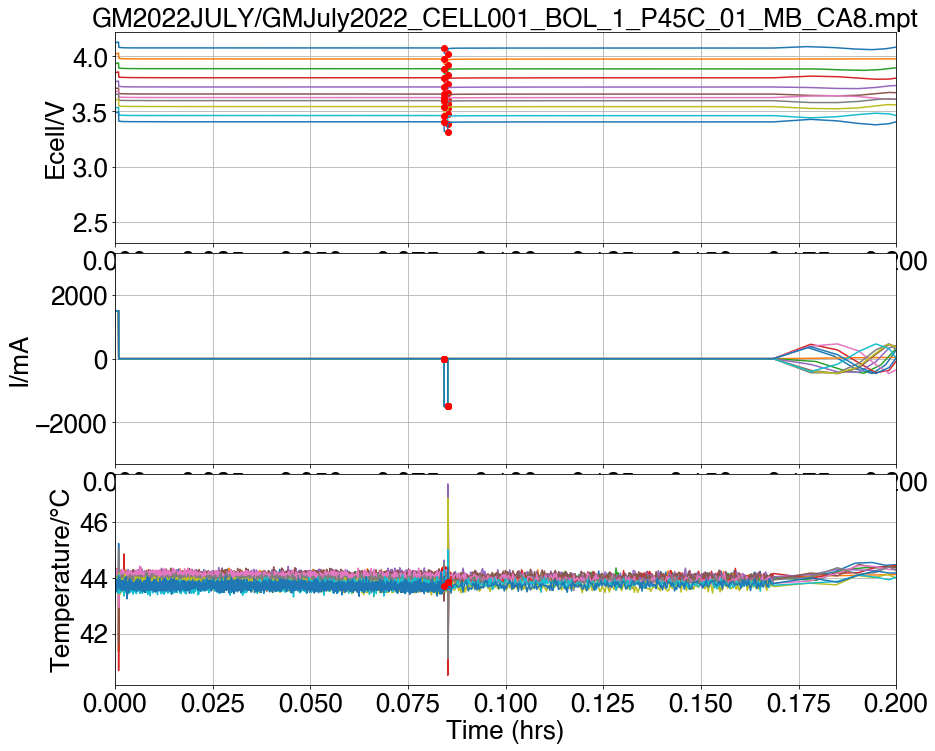

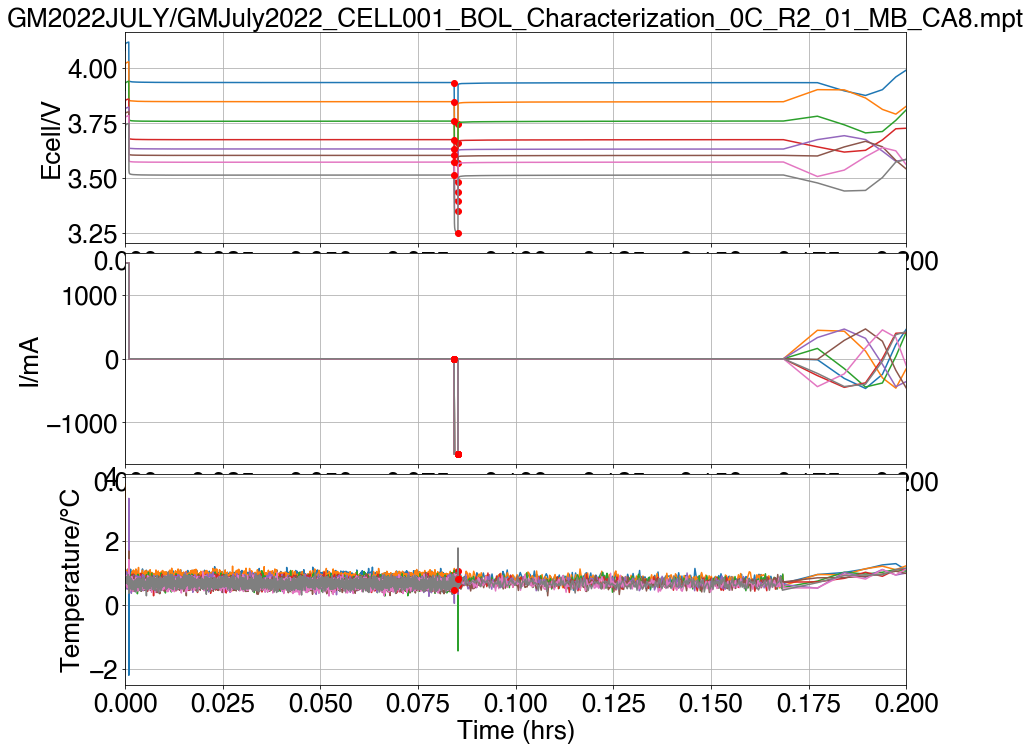

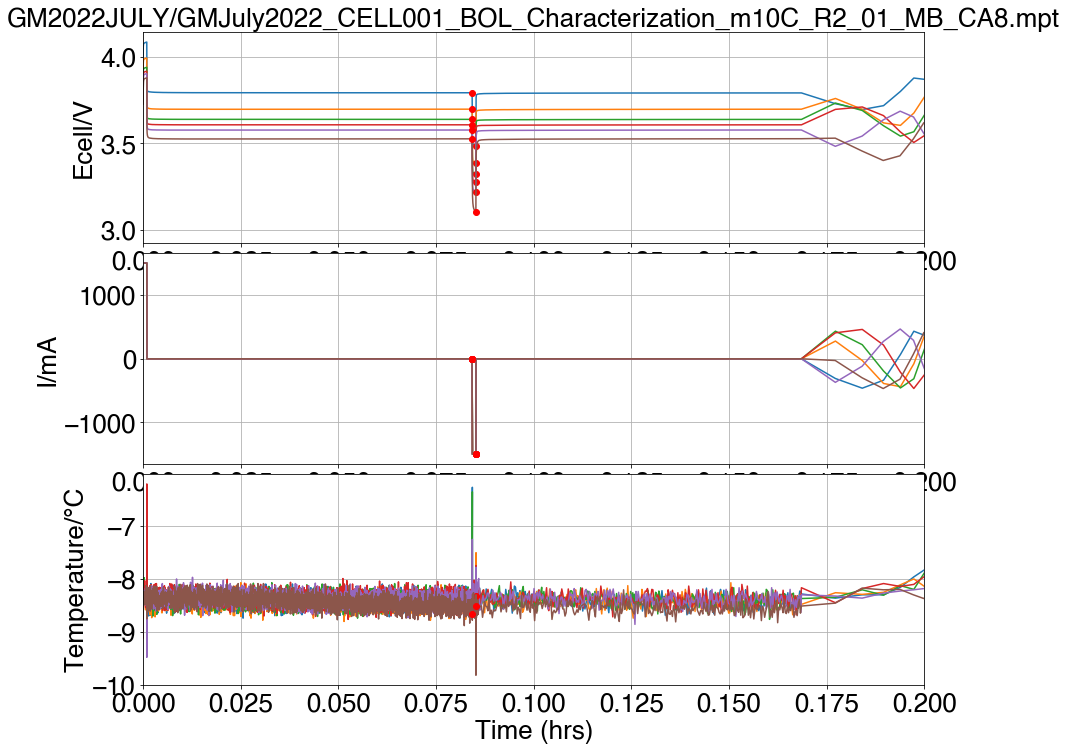

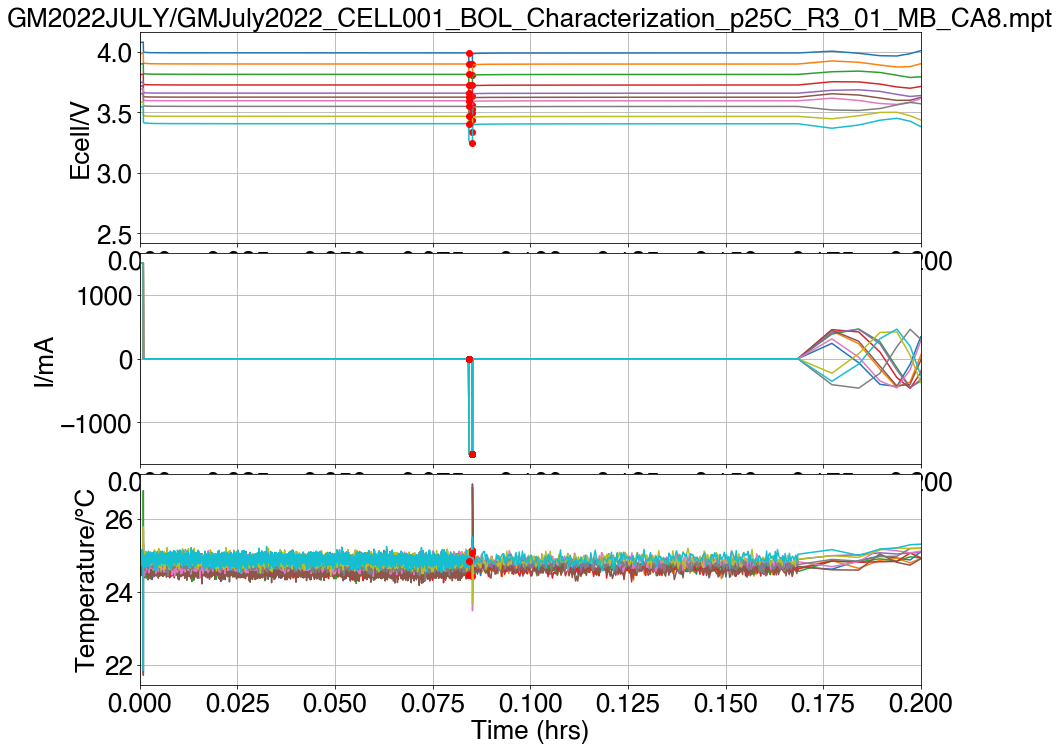

In [9]:
is_pulse_current = lambda I : (I > -2) & (I < -1)

vars = ['Ecell/V',
        'I/mA',
        'Temperature/°C'
        ]

v0_list = []
vf_list = []
r_ohms_list = []
time_s_list = []
temp_c_list = []
temp_target_c_list = []
current_a_list = []
capacity_ah_list = []

for df, temp_target, file_name in zip(df_list, temperature_targets, files_list):

    gridspec = dict(hspace=0.05, height_ratios=np.ones(len(vars)))

    fig, axs = plt.subplots(nrows=len(vars), ncols=1, 
                                    gridspec_kw=gridspec, 
                                    figsize=(14, 4*len(vars)))


    unique_cycles = df['cycle number'].unique()

    for icyc in unique_cycles:

        # Identify the right cycle indices corresponding to the pulse data
        if icyc % 2 == 1 or icyc == 0:
            continue

        this_df = df[df['cycle number'] == icyc]
        prev_df = df[df['cycle number'] == icyc - 2] # to fetch capacity
        x = this_df['time/s'] - np.min(this_df['time/s'])
        x = x/3600
        I = this_df['I/mA'] / 1000
        E = this_df['Ecell/V']
        T = this_df['Temperature/°C']
        Q = prev_df['Q discharge/mA.h'] / 1000

        idx = np.where(is_pulse_current(I))[0]
        idx_v0 = idx[0] - 1

        idx_end = idx_v0 + 1 # Initialization
        while True:
            idx_end += 1
            if not is_pulse_current(I.iloc[idx_end]):
                idx_end -= 1
                break

        v0_list.append(E.iloc[idx_v0])
        vf_list.append(E.iloc[idx_end])
        current_a_list.append( np.median(I.iloc[idx_v0:idx_end]) )
        r_ohms_list.append( (E.iloc[idx_end] - E.iloc[idx_v0] ) / np.median(I.iloc[idx_v0:idx_end]))
        time_s_list.append((x.iloc[idx_end] - x.iloc[idx_v0] ) * 3600 )
        temp_c_list.append(T.iloc[idx_v0])
        temp_target_c_list.append(temp_target)
        capacity_ah_list.append(np.max(Q))
        
        # Make some debug plots
        for var, ax in zip(vars, axs):

            y = this_df[var]
            ax.plot(x, y)
            ax.plot(x.iloc[idx_v0], y.iloc[idx_v0], marker='o', markersize=6, color='r')
            ax.plot(x.iloc[idx_end], y.iloc[idx_end], marker='o', markersize=6, color='r')
            ax.set_ylabel(var)
            ax.set_xlim((0, 0.2))

        axs[-1].set_xlabel('Time (hrs)')
        axs[0].set_title(file_name)

# Format final outputs

out = dict()
out['v0'] = v0_list
out['vf'] = vf_list
out['current_a'] = current_a_list
out['temp_target_c'] = temp_target_c_list
out['temp_meas_c'] = temp_c_list
out['duration_s'] = time_s_list
out['capacity_ah'] = capacity_ah_list
out['r_ohms'] = r_ohms_list

df_out = pd.DataFrame(out)

In [10]:
df_out

,v0,vf,current_a,temp_target_c,temp_meas_c,duration_s,capacity_ah,r_ohms
0,4.075544,4.021036,-1.498461,45,44.116413,3.458,0.301672,0.036376
1,3.975389,3.921983,-1.498461,45,43.958797,3.444,0.302975,0.035641
2,3.887482,3.834036,-1.498658,45,43.927273,3.460,0.303212,0.035662
3,3.805482,3.751486,-1.498658,45,43.950916,3.474,0.303201,0.036030
4,3.722065,3.666336,-1.498658,45,44.061249,3.492,0.302894,0.037186
5,3.657750,3.602138,-1.498658,45,44.313438,3.482,0.303210,0.037108
6,3.626005,3.567873,-1.498658,45,43.935158,3.454,0.303254,0.038790
7,3.597885,3.535578,-1.498461,45,43.864227,3.476,0.302827,0.041581
8,3.544085,3.476146,-1.498461,45,43.722370,3.446,0.303263,0.045339
9,3.462834,3.385285,-1.498658,45,43.777538,3.448,0.303274,0.051746


# Fruits of our labor

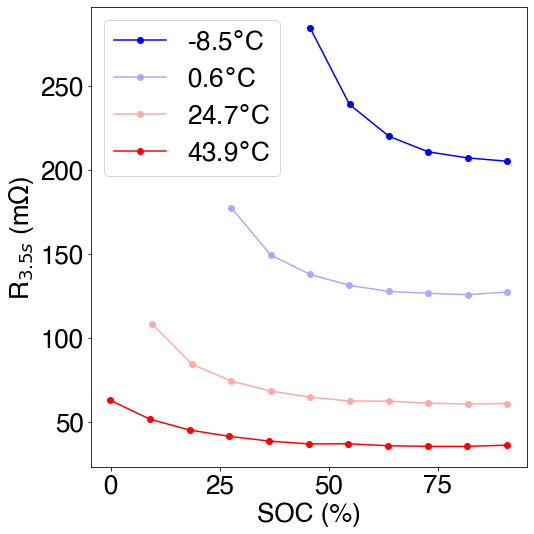

In [11]:
unique_temps = df_out['temp_target_c'].unique()
unique_temps = np.sort(unique_temps)

fh = plt.figure(figsize=(8,8))

color = plt.cm.bwr(np.linspace(0, 1, len(unique_temps)))

for temp_target, col in zip(unique_temps, color):

    curr_df = df_out[df_out['temp_target_c'] == temp_target]

    x = NOMINAL_CAPACITY_AH - np.cumsum(curr_df['capacity_ah'])
    y = curr_df['r_ohms'] * 1000
    temp = np.median(curr_df['temp_meas_c'])

    plt.plot((x / NOMINAL_CAPACITY_AH) * 100, y, label=f'{temp:.1f}$\degree$C',
                   color=col,
                   marker='o')
    plt.xlabel('SOC (%)')
    plt.ylabel('R$_{3.5s}$ (m$\Omega$)')
    plt.legend()
    plt.grid(False)

In [12]:
# Verifying the value of the 'nominal capacity'
df_out[df_out['temp_target_c'] == 45]['capacity_ah'].sum()

3.3329357950919962

In [13]:
unique_temps
df_out

,v0,vf,current_a,temp_target_c,temp_meas_c,duration_s,capacity_ah,r_ohms
0,4.075544,4.021036,-1.498461,45,44.116413,3.458,0.301672,0.036376
1,3.975389,3.921983,-1.498461,45,43.958797,3.444,0.302975,0.035641
2,3.887482,3.834036,-1.498658,45,43.927273,3.460,0.303212,0.035662
3,3.805482,3.751486,-1.498658,45,43.950916,3.474,0.303201,0.036030
4,3.722065,3.666336,-1.498658,45,44.061249,3.492,0.302894,0.037186
5,3.657750,3.602138,-1.498658,45,44.313438,3.482,0.303210,0.037108
6,3.626005,3.567873,-1.498658,45,43.935158,3.454,0.303254,0.038790
7,3.597885,3.535578,-1.498461,45,43.864227,3.476,0.302827,0.041581
8,3.544085,3.476146,-1.498461,45,43.722370,3.446,0.303263,0.045339
9,3.462834,3.385285,-1.498658,45,43.777538,3.448,0.303274,0.051746


# Plot Temperature on the X-Axis

Interpolate the 'SOC'-dependence so we can take some slices at fixed SOC points

In [14]:
soc_targets = np.array([5, 30, 50, 90]) / 100
cap_targets = (1 - soc_targets) * NOMINAL_CAPACITY_AH

r_ohm_list = []
temp_c_list = []
cap_ah_list = []

for temp in unique_temps:

    curr_df = df_out[df_out['temp_target_c'] == temp]

    x = np.cumsum(curr_df['capacity_ah'])
    y = curr_df['r_ohms']

    for cap in cap_targets:

        cap_ah_list.append(cap)
        temp_c_list.append(np.median(curr_df['temp_meas_c']))

        if cap < max(x):
            r_ohm_list.append(np.interp(cap, x, y))
        else:
            r_ohm_list.append(np.NaN)


out = dict()
out['cap_ah'] = cap_ah_list
out['temp_c'] = temp_c_list 
out['r_ohms'] = r_ohm_list
df_by_temp = pd.DataFrame(out)

In [15]:
df_by_temp

,cap_ah,temp_c,r_ohms
0,3.16255,-8.516023,NaN
1,2.33030,-8.516023,NaN
2,1.66450,-8.516023,0.262757
3,0.33290,-8.516023,0.205229
4,3.16255,0.602154,NaN
5,2.33030,0.602154,0.170034
6,1.66450,0.602154,0.134727
7,0.33290,0.602154,0.127174
8,3.16255,24.725520,NaN
9,2.33030,24.725520,0.072909


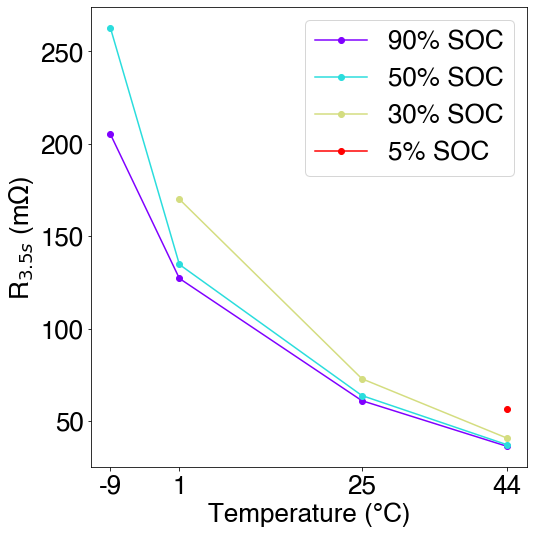

In [16]:
fh = plt.figure(figsize=(8,8))

unique_caps = np.unique(cap_ah_list)

color = plt.cm.rainbow(np.linspace(0, 1, len(unique_caps)))

for cap, col in zip(unique_caps, color):

    curr_df = df_by_temp[df_by_temp['cap_ah'] == cap]

    x = curr_df['temp_c']
    y = curr_df['r_ohms'] * 1000

    plt.plot(x, y, label=f'{100 - cap/NOMINAL_CAPACITY_AH*100:.0f}% SOC',
                   color=col,
                   marker='o')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('R$_{3.5s}$ (m$\Omega$)')
    plt.legend()
    plt.xticks(x)
    plt.grid(False)
    plt.gca().set_xticklabels(['{:.0f}'.format(f) for f in x])


In [18]:
df_by_temp

,cap_ah,temp_c,r_ohms
0,3.16255,-8.516023,NaN
1,2.33030,-8.516023,NaN
2,1.66450,-8.516023,0.262757
3,0.33290,-8.516023,0.205229
4,3.16255,0.602154,NaN
5,2.33030,0.602154,0.170034
6,1.66450,0.602154,0.134727
7,0.33290,0.602154,0.127174
8,3.16255,24.725520,NaN
9,2.33030,24.725520,0.072909
